# Computing measures of spatial dependence

In [ ]:
!pip install datasets

In [ ]:
!pip install cartoframes

In [3]:
import datasets
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-poster")

# Measuring spatial dependence for continous spatial processes: variograms

The meuse dataset in the R package <b>gstat</b> (Pebesma, 2004) contains measurements of heavy metals concentrations in the area of the Meuse river, near the village of Stein (The Netherlands).

The Coordinate Reference System (CRS) is the Netherlands topographical map, and the coordinates are measured in meters.

|Variable |	Description|
| --- | --- |
| cadmium  |	Topsoil cadmium concentration (in ppm)
| copper  |	Topsoil copper concentration (in ppm)
| lead |	Topsoil lead concentration (in ppm)
| zinc |	Topsoil zinc concentration (in ppm)
| elev |	Relative elevation above local river bed (in meters)
| dist |	Disance to the Meuse river (normalised to  (0,1))
| om  |	Organic matter (in percentage)
| ffreq  |	Flooding frequency (1 = once in two years; 2 = once in ten years; 3 = once in 50 years)
| soil  |	Soil type (1 = Rd10A; 2 = Rd90C/VII; 3 = Bkd26/VII)
| lime |	Lime class (0 = absent; 1 = present)
| landuse |	Landuse class
| dist.m |	Distance to the river (in meters)

### Let's read in the data

In [4]:
from cartoframes import read_carto
from cartoframes.auth import set_default_credentials, Credentials
set_default_credentials("ebook-sds")

data_pf = read_carto("meuse")
data_pf.head()

,cartodb_id,the_geom,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist_m
0,1,POINT (5.75854 50.99156),181072.0,333611.0,11.7,85.0,299.0,1022.0,7.909,0.001358,13.6,1.0,1.0,1.0,Ah,50.0
1,2,POINT (5.75786 50.99109),181025.0,333558.0,8.6,81.0,277.0,1141.0,6.983,0.012224,14,1.0,1.0,1.0,Ah,30.0
2,3,POINT (5.75986 50.99089),181165.0,333537.0,6.5,68.0,199.0,640.0,7.800,0.103029,13,1.0,1.0,1.0,Ah,150.0
3,4,POINT (5.76175 50.99041),181298.0,333484.0,2.6,81.0,116.0,257.0,7.655,0.190094,8,1.0,2.0,0.0,Ga,270.0
4,5,POINT (5.76186 50.98903),181307.0,333330.0,2.8,48.0,117.0,269.0,7.480,0.277090,8.7,1.0,2.0,0.0,Ah,380.0


In [5]:
meuse = data_pf.zinc

In [9]:
import numpy as np
data_pf['log_zinc'] = np.log(data_pf['zinc'])
meuse = data_pf.to_crs({'init': 'epsg:28992'})
meuse_lonlat = data_pf.to_crs({'init': 'epsg:4326'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Let's plot the data

In [10]:
from cartoframes.viz import Map, Layer, color_continuous_style,color_continuous_legend,basemaps

Map(
    Layer(meuse_lonlat,
        style = color_continuous_style('zinc',
                               palette="Temps"),
        legends=color_continuous_legend(title="Topsoil zinc concentration (in ppm)")
    ),
    show_info=True
)

### Let's compute the variogram

Here we compute the variogram using the Variogram function in the [<b>skgstat</b> Python package](https://pypi.org/project/scikit-gstat/). We will compute the empirical semivariogram and fit both an exponential 

$$\gamma(d) = \tau + \sigma^2 \left(1 - exp\left(- \frac{d}{\rho} \right)\right)$$

and a Matérn model

$$\gamma_{\nu} (d) = \tau + \sigma^2 \left(1 - \frac{2^{1 - \nu}}{\Gamma(\nu)} \left(\sqrt{2\nu}\frac{d}{\rho}\right)^{\nu} K_{\nu}\left(\sqrt{2\nu}\frac{d}{\rho}\right)\right)$$

where $d$ is the distance between two observations, $\Gamma(\cdot)$ is the gamma function and $K_{\nu}(\cdot)$ is the modified Bessel function of the second kind. $\tau$ (the nugget or the measurement error), $\sigma^2$ (the partial-sill or the scale), $\rho$ (the range) and $\nu$ are non-negative parameters.

While variograms can be computed to describe the spatial dependence of a sample (as in the following example), they can also be obtained for the residuals of a regression model, as is required in a spatial modelling context (c.f. the dedicated notebook Chapter 1 - Spatial modelling for continous spatial processes).

In [13]:
!pip install scikit-gstat

     |████████████████████████████████| 2.1 MB 4.4 MB/s 
  Created wheel for scikit-gstat: filename=scikit_gstat-1.0.1-py3-none-any.whl size=703496 sha256=e105f26a73ce43cbe9d63a9d35aa1686eaaf2c858dbcef73c3bfa6e72e29afa7
  Stored in directory: /root/.cache/pip/wheels/0e/66/1b/692968c08959d21040075395a1e2e15ffd71823034691e1778
Successfully built scikit-gstat


In [14]:
from skgstat import Variogram
import pandas as pd

### Exponential model

In [17]:
coordinates = pd.concat([meuse.x, meuse.y], axis=1).values

# zinc concentration levels
levels = np.log(meuse.zinc).values

vg_exponential = Variogram(
    coordinates=coordinates,
    values=levels,
    normalize=False,
    use_nugget=True,
    model="exponential",
    maxlag=3000,
    n_lags=10,
)

print(vg_exponential)

exponential Variogram
---------------------
Estimator:         matheron
Effective Range:   1008.12
Sill:              0.56
Nugget:            0.00
        


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

def Variogram_plot(v, fig_title=None, axes=None, grid=True, show=False, hist=True):
        """Variogram Plot
        Plot the experimental variogram, the fitted theoretical function and
        an histogram for the lag classes. The axes attribute can be used to
        pass a list of AxesSubplots or a single instance to the plot
        function. Then these Subplots will be used. If only a single instance
        is passed, the hist attribute will be ignored as only the variogram
        will be plotted anyway.
        Parameters
        ----------
        axes : list, tuple, array, AxesSubplot or None
            If None, the plot function will create a new matplotlib figure.
            Otherwise a single instance or a list of AxesSubplots can be
            passed to be used. If a single instance is passed, the hist
            attribute will be ignored.
        grid : bool
            Defaults to True. If True a custom grid will be drawn through
            the lag class centers
        show : bool
            Defaults to True. If True, the show method of the passed or
            created matplotlib Figure will be called before returning the
            Figure. This should be set to False, when used in a Notebook,
            as a returned Figure object will be plotted anyway.
        hist : bool
            Defaults to True. If False, the creation of a histogram for the
            lag classes will be suppressed.
        Returns
        -------
        matplotlib.Figure
        """
        # get the parameters
        _bins = v.bins
        _exp = v.experimental
        x = np.linspace(0, np.nanmax(_bins), 100)  # make the 100 a param?

        # do the plotting
        if axes is None:
            if hist:
                fig = plt.figure(figsize=(8, 5))
                ax1 = plt.subplot2grid((5, 1), (1, 0), rowspan=4)
                ax2 = plt.subplot2grid((5, 1), (0, 0), sharex=ax1)
                fig.subplots_adjust(hspace=0)
            else:
                fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
                ax2 = None
        elif isinstance(axes, (list, tuple, np.ndarray)):
            ax1, ax2 = axes
            fig = ax1.get_figure()
        else:
            ax1 = axes
            ax2 = None
            fig = ax1.get_figure()

        # apply the model
        y = v.transform(x)

        # handle the relative experimental variogram
        if v.normalized:
            _bins /= np.nanmax(_bins)
            y /= np.max(_exp)
            _exp /= np.nanmax(_exp)
            x /= np.nanmax(x)

        # ------------------------
        # plot Variograms
        ax1.plot(_bins, _exp, marker=".", color='orange', markersize=15, linestyle='None')
        ax1.plot(x, y, 'blue', linewidth=2)
        ax1.set_facecolor('white')

        # ax limits
        if v.normalized:
            ax1.set_xlim([0, 1.05])
            ax1.set_ylim([0, 1.05])
        if grid:
            ax1.grid('off')
            ax1.vlines(_bins, *ax1.axes.get_ybound(), colors=(.85, .85, .85),
                       linestyles='dashed',linewidth=0.5)
        # annotation
        ax1.axes.set_ylabel('semivariance (%s)' % v._estimator.__name__)
        ax1.axes.set_xlabel('Lag (-)')

        # ------------------------
        # plot histogram
        if ax2 is not None and hist:
            # calc the histogram
            _count = np.fromiter(
                (g.size for g in v.lag_classes()), dtype=int
            )

            # set the sum of hist bar widths to 70% of the x-axis space
            w = (np.max(_bins) * 0.7) / len(_count)

            # plot
            ax2.bar(_bins, _count, width=w, align='center', color='blue')

            # adjust
            plt.setp(ax2.axes.get_xticklabels(), visible=False)
            ax2.axes.set_yticks(ax2.axes.get_yticks()[1:])

            # need a grid?
            if grid:
                ax2.grid('off')
                ax2.vlines(_bins, *ax2.axes.get_ybound(),
                           colors=(.85, .85, .85), linestyles='dashed',linewidth=0.5)

            # anotate
            ax2.axes.set_ylabel('N')
            ax2.set_facecolor('white')

        plt.title(fig_title)
        return fig

def geom2gdf(geom, crs, lonlat = True):
    geom = [['geom', geom]]
    geom = pd.DataFrame(geom, columns = ['geom', 'geometry'])
    geom = gpd.GeoDataFrame(geom, geometry=geom.geometry)
    geom.crs = {'init': crs}
    if(lonlat):
        geom = geom.to_crs({'init': 'epsg:4326'})

    return geom

def ell2gdf(M, sMx, sMy, theta, crs):
    circ = shapely.geometry.Point(M).buffer(1)
    ell  = shapely.affinity.scale(circ, int(sMx), int(sMy))
    ellr = shapely.affinity.rotate(ell,-np.degrees(theta))
    poly = geom2gdf(ellr, crs)

    return poly

def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.
    Parameters
    ----------
    nc_fid : netCDF4.Dataset
       A netCDF4 dateset object
    verb : Boolean
       whether or not nc_attrs, nc_dims, and nc_vars are printed
    Returns
    -------
    nc_attrs : list
       A Python list of the NetCDF file global attributes
    nc_dims : list
       A Python list of the NetCDF file dimensions
    nc_vars : list
       A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key
        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)
    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim)
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

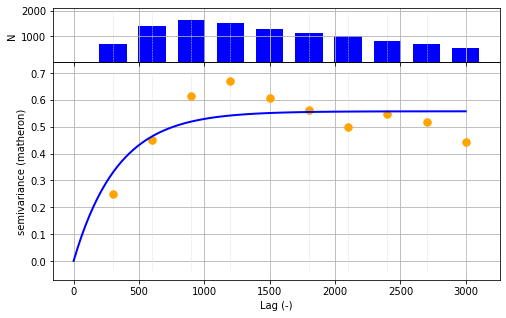

In [23]:
ax = Variogram_plot(vg_exponential)

# Measuring spatial dependence for discrete spatial processes: Moran's statistics 

The boston housing dataset, records housing values in Boston census tracts (Harrison and Rubinfeld, 1978) corrected for a few errors (Gilley and Pace, 1996).

The CRS is given by the longitude and latitude of the observations (Bivand, 2017).

|Variable |	Description|
| --- | --- |
|town |	Town name
|medv | Median value of owner-occupied homes (in USD 1,000)
|cmedv | Corrected median value of owner-occupied housing (in USD 1,000)
|crim | Crime per capita
|zn	| Proportions of residential land zoned for lots over 25,000 sq. ft per town
|indus |	Proportions of non-retail business acres per town
|chas |	Whether the tract borders Charles river (1 = yes, 0 = no)
|nox |	Nitric oxides concentration (in parts per 10 million)
|rm |	Average number of rooms per dwelling
|age |	Proportions of owner-occupied units built prior to 1940
|dis |	Weigthed distances to five Boston employment centres
|rad |	Index of accesibility to radial highways per town
|tax |	Full-value property-tax rate per USD 10,000 per town
|ptratio |	Pupil-teacher ratios per town
|b	 | $1000*(B - 0.63)^2$ where $B$ is the proportion of  people of African American descent by town
|lstat | Percentage of lower status of the population

### Let's read in the data

In [31]:
boston = read_carto("boston_housing")
boston.head()

,cartodb_id,the_geom,poltract,town,townno,tract,lon,lat,medv,cmedv,...,c15_20,c20_25,c25_35,c35_50,co50k,median,bb,censored,nox_id,pop
0,175,"MULTIPOLYGON (((-70.94999 42.47270, -70.94769 ...",2062,Lynn,4.0,2062.0,-70.9693,42.2816,15.6,15.6,...,92.0,20.0,5.0,0.0,0.0,15600.0,0.6,no,23.0,4910.0
1,294,"MULTIPOLYGON (((-71.08780 42.37340, -71.08260 ...",3522,Cambridge,28.0,3522.0,-71.0519,42.2230,15.6,15.6,...,12.0,3.0,4.0,1.0,0.0,15600.0,0.6,no,48.0,1461.0
2,316,"MULTIPOLYGON (((-71.13130 42.38230, -71.14010 ...",3544,Cambridge,28.0,3544.0,-71.0820,42.2295,25.0,25.0,...,8.0,16.0,13.0,15.0,5.0,25000.0,14.3,no,49.0,2255.0
3,410,"MULTIPOLYGON (((-71.12360 42.35140, -71.12440 ...",4003,Brookline,45.0,4003.0,-71.0765,42.2075,30.1,30.1,...,2.0,31.0,65.0,34.0,3.0,30100.0,0.6,no,68.0,4542.0
4,424,"MULTIPOLYGON (((-71.21810 42.26760, -71.21781 ...",4025,Dedham,46.0,4025.0,-71.1170,42.1510,35.2,35.2,...,52.0,96.0,196.0,163.0,209.0,35200.0,0.6,no,70.0,3712.0


### Let's plot the data

In [26]:
Map(
    Layer(boston,
        style = color_continuous_style('cmedv',
                               opacity=0.7),
        legends=color_continuous_legend(title="Corrected median value of owner-occupied housing (in USD 1,000)")
    ),
    show_info=True
)

### Let's compute global Moran's I coefficient

Here we compute Moran's I coefficient for the cmedv variable in the Boston housing data ($I$) and compare it to its (asymptotic) mean and variance under the null hypothesis of no spatial dependence using the Python package <b>PySAL</b> (Rey and Anselin, 2007). The weights are computed assuming that two areas are neighbours if they share at least a segment (queen adjacency).

In [ ]:
!pip install esda

In [29]:
import esda

In [33]:
from libpysal.weights import Queen
w = Queen.from_dataframe(boston)

In [34]:
Moran_cmedv = esda.Moran(boston.cmedv, w, permutations=1000)
print("Moran's I: {0:.{1}f}".format(Moran_cmedv.I, 3))
print("Moran's E[I]: {0:.{1}f}".format(Moran_cmedv.EI, 3))
print("Moran's Var[I]: {0:.{1}f}".format(Moran_cmedv.VI_norm, 3))

Moran's I: 0.632
Moran's E[I]: -0.002
Moran's Var[I]: 0.001


To test the significance of the rejection of independence, we can then extract, by using a Monte Carlo approach, a sample of random permutations of the variable of interest (cmedv) to the spatial entities, compute Moran's I for each sample and then compare the observed value to this distribution of simulated Moran's I statistics (via an empirical p-value).

In [35]:
import seaborn as sns

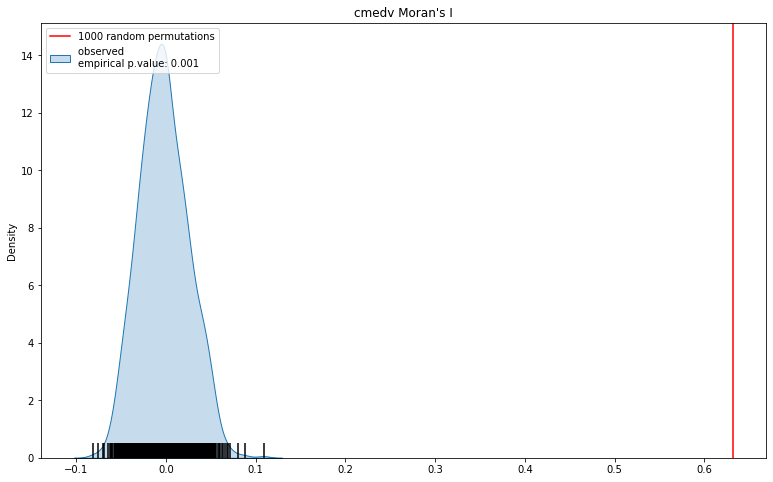

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
sns.kdeplot(Moran_cmedv.sim, shade=True, ax=ax)
ax.axvline(Moran_cmedv.I, 0, 10, color="r")
ax.set_title("cmedv Moran's I")
ax.legend(["1000 random permutations", "observed \nempirical p.value: " + str(round(Moran_cmedv.p_sim,3))])
ax.vlines(Moran_cmedv.sim, 0, 0.5)

The result of applying Moran's I is that we conclude the spatial patterns in cvmed is not random, and instead there is a signficant spatial dependence in the value of the owner-occupied housing.

### Let's compute local Moran's I coefficient

In addition to the global measure provided by Moran's I coefficient, we can detect the clusters using Local Indicators of Spatial Association (LISA). For each census tract we can compute a Local Moran's I value ($LMI$). If the $LMI$ value is positive this indicates neighbors with similarly high or low values, and, if negative, indicates neighbors with dissimilar values.

In [37]:
LMoran_cmdev = esda.Moran_Local(
    boston.cmedv, w, permutations=1000
)

Again, using a Monte Carlo approach, we can test the significance of the results under a given significance level.

In [38]:
sig_level = 0.05
sig = LMoran_cmdev.p_sim < sig_level
hotspots = LMoran_cmdev.q == 1 * sig
coldspots = LMoran_cmdev.q == 3 * sig

boston["LMI_cat"] = f"Non significant ({sig_level}) significance level)"
boston.loc[hotspots, "LMI_cat"] = "Cluster - LMI > 0"
boston.loc[coldspots, "LMI_cat"] = "Outlier - LMI < 0"

In [39]:
from cartoframes.viz import color_category_style, color_category_legend

In [40]:
Map(
    Layer(boston,
        style = color_category_style(
            "LMI_cat",
            cat=[
                "Cluster - LMI > 0",
                "Outlier - LMI < 0",
                f"Non significant ({sig_level} significance level)",
            ],
            palette=["crimson", "royalblue", "grey"],
            opacity=0.5,
            stroke_color="transparent"),
        legends = color_category_legend(title="Clusters/outliers according to Local Moran's I (LMI)",
                                      description="Corrected median value of owner-occupied housing (in USD 1,000)")
    ),
    show_info=True,
)

# Assessing randomness/clustering for point patterns

Police in Britain makes pubicly available the locations and the types of the reported crimes (http://data.police.uk/). For example we can download these data for the London area in April 2019.

The coordinates are originally given as longitude and latitude but, in order to have them measured in meters, we transformed the CRS to EPSG:32630 (UTM zone 30N).

|ID | Variable |
| --- | --- |
|Crime_ID |Crime_type (Violence and sexual offences, Anti-social behaviour, Burglary, Criminal damage and arson, Drugs, Other theft,Public order, Vehicle crime, Robbery, Shoplifting,Possession of weapons, Bicycle theft, Other crime, Theft from the person)

In [41]:
from shapely.geometry import Point

In [49]:
crime_london = read_carto('uk_police_street_crimes_2019_04')
crime_london.head()

,cartodb_id,the_geom,unnamed__0,crime_id,month,reported_by,falls_within,longitude,latitude,location,lsoa_code,lsoa_name,crime_type,last_outcome_category,context
0,1,POINT (0.13555 51.58499),10.0,27ba7c00801cbfd96d3843051814f019aede1c6d51a6aa...,2019-04,Metropolitan Police Service,Metropolitan Police Service,0.135554,51.584985,On or near Rose Lane,E01000027,Barking and Dagenham 001A,Burglary,Under investigation,None
1,2,POINT (0.14843 51.59516),11.0,7566fdb03eb3c4ca3ad3f5ec7b09e0126d5c9f2cd9825d...,2019-04,Metropolitan Police Service,Metropolitan Police Service,0.148434,51.595164,On or near Park/Open Space,E01000027,Barking and Dagenham 001A,Burglary,Under investigation,None
2,3,POINT (0.13512 51.57849),51.0,cdcce05d8b40d43bd8aa66a23d617a05ab329703599ee8...,2019-04,Metropolitan Police Service,Metropolitan Police Service,0.135119,51.578492,On or near Portland Close,E01000029,Barking and Dagenham 001C,Burglary,Under investigation,None
3,4,POINT (0.13391 51.57329),89.0,c945cbce31d46db4dd3e38ac3c82084be977f4ee526b80...,2019-04,Metropolitan Police Service,Metropolitan Police Service,0.133908,51.573289,On or near Mayfair Avenue,E01000032,Barking and Dagenham 002B,Burglary,Under investigation,None
4,5,POINT (0.14198 51.57220),144.0,72520bc03de4189c5b817f3fa673a069b9bdd7cb5c87b4...,2019-04,Metropolitan Police Service,Metropolitan Police Service,0.141982,51.572197,On or near Whalebone Lane North,E01000112,Barking and Dagenham 002E,Burglary,Under investigation,None


In [ ]:
!pip install pointpats

### Let's compute some measures of central tendency and dispersion 

Given a series of coordinates $(x,y)$ the simplest measures of central tendency for a point pattern process is the Mean Center
    
$$\text{M} = \left( x_c := \dfrac{1}{n} \sum_i x_i,\, y_c := \dfrac{1}{n} \sum_i y_i \right) $$

Other measures include the manhattan median and euclidan medians (see PySAL documentation https://pysal.readthedocs.io/en/latest/ for more details). For marked point patterns an equivalent measure is given by the Weighted Mean Center

$$\text{WM} = \left( x_c := \dfrac{\sum_i w_i x_i}{\sum_i w_i},\, y_c := \dfrac{\sum_i w_i y_i}{\sum_i w_i}\right)$$

In [ ]:
from pointpats.centrography import mean_center, ellipse
from pointpats import PointPattern

In [60]:
pp = PointPattern([crime_london.longitude,crime_london.latitude])

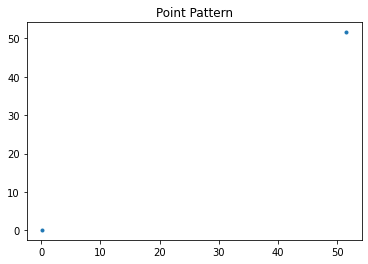

In [62]:
pp.plot()

In [58]:
pp

In [56]:
M = mean_center(pp)

AxisError: ignored

As a measure of dispersion and to account for possible differences between the two dimensions, we can compute the standard deviational ellipse 

$$\text{sM}_x =  \sqrt{\dfrac{2\big(\sum_i \,(x_i - x_c) \, cos\theta - \sum_i \, (y_i - y_c) \, sin\theta\big)^2}{n-2}} $$

$$\text{sM}_y =  \sqrt{\dfrac{2\big(\sum_i \,(x_i - x_c) \, sin\theta - \sum_i \, (y_i - y_c) \, cos\theta\big)^2}{n-2}} $$

In [ ]:
from pointpats import ellipse

sMx, sMy, theta = ellipse(crime_london.pointpattern.points)

Finally we can compute the intensity on the smallest convex set that contains the data (i.e. the convex hull)

$$ \lambda_{hull} = \dfrac{n}{|W_{hull}|}$$

where $|W_{hull}|$ is the convex hull area. Other measures of intensity are possible, and depend on the definition of the study region (or window). 

In [ ]:
print(
    "Convex hull based intensity: {:.2E}".format(crime_london.pointpattern.lambda_hull)
)

Convex hull based intensity: 3.36E-06


#### Let's plot a map of the computed measures

In [ ]:
from shapely.geometry import Polygon
from pointpats import hull
import utils
from cartoframes.viz import basic_style



M_point = utils.geom2gdf(Point(M), list(crime_london.data.crs.values())[0])
hull_poly = utils.geom2gdf(
    Polygon(hull(crime_london.pointpattern.points)),
    list(crime_london.data.crs.values())[0],
)
ell_poly = utils.ell2gdf(M, sMx, sMy, theta, list(crime_london.data.crs.values())[0])

ramp = "opacity(red,.5)"
Map(
    [
        Layer(
            crime_london.data_lonlat,
            style = basic_style(color = 'blue',
                                opacity = .1,
                                size = 5),
            legends=color_category_legend(title="Burglary crimes", 
                                          description =  "UK Police Apr 2019"),
        ),
        Layer(hull_poly, "color: opacity(red,.0) strokeWidth: 2"),
        Layer(ell_poly, "color: opacity(red,.1) strokeWidth: 2"),
        Layer(M_point, "color: opacity(red,1) strokeWidth: 2"),
    ],
    show_info=True,
)

### Let's assess if the data are generated from a process characterized by Complete Spatial Randomness (CSR)

Assessing if a point pattern is random is a crucial step of the analysis. Complete Spatial Randomness (CSR) implies that the location of one observation does not affect the probability of another being observed nearby. 

#### Quadrat statistics

To assess if a point process is not random, in PySAL we can construct an empirical sampling distribution from a large number of $\chi^2$ test statistics derived comparing the observed point counts against the expected counts under the CSR hypothesis in a $n_x \times n_y$ rectangular tessellation over the study area (window). We can then calculate a pseudo p-value which we can use to make the decision (see PySAL documentation https://pysal.readthedocs.io/en/latest/ for more details)

In [ ]:
from pointpats import PoissonPointProcess
from pointpats.quadrat_statistics import QStatistic

csr_process = PoissonPointProcess(
    crime_london.pointpattern.window, crime_london.pointpattern.n, 1000, asPP=True
)

q_r = QStatistic(
    crime_london.pointpattern, shape="rectangle", nx=3, ny=3, realizations=csr_process
)
print("Pseudo p-value: {0:.3f}".format(q_r.chi2_r_pvalue))

Pseudo p-value: 0.001


#### G-function (Cressie, 1991)

We can also compute the nearest neighbour distance distribution function (also called the event-to-event distribution) of a point process. This is the cumulative distribution function G of the distance from a typical random point to the nearest other point (http://pysal.org/notebooks/explore/pointpats/distance_statistics). If the estimate of the function G  calculated from the data is above (below) the G function computed for a complete spatial random point pattern, this suggests that the point process is characterized by a clustered (regular) distribution.

Text(0, 0.5, '')

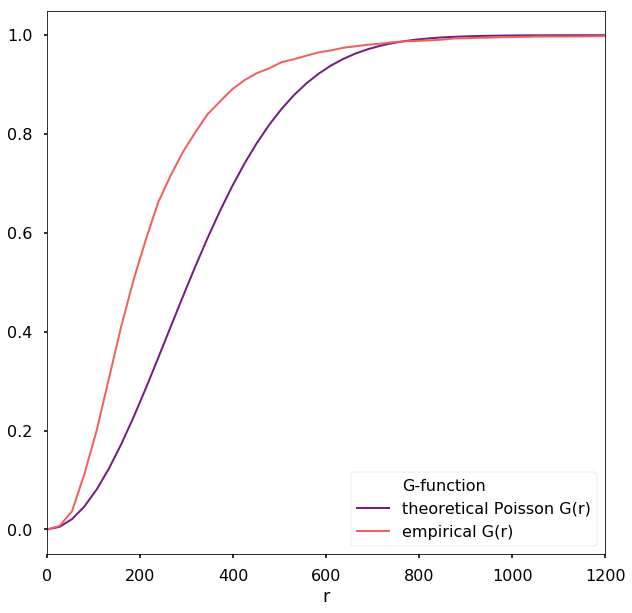

In [ ]:
from pointpats import G

gfun = G(crime_london.pointpattern, intervals=100)
gfun_ev = pd.DataFrame(np.vstack((gfun.d, gfun.ev)).T, columns=["r", "vals"])
gfun_ev["G-function"] = "theoretical Poisson G(r)"
gfun_G = pd.DataFrame(np.vstack((gfun.d, gfun.G)).T, columns=["r", "vals"])
gfun_G["G-function"] = "empirical G(r)"
gfun_df = pd.concat([gfun_ev, gfun_G])

plt.figure(figsize=(10, 10))
palette = sns.color_palette("magma", 2)
ax = sns.lineplot(
    x="r",
    y="vals",
    hue="G-function",
    palette=palette,
    size="G-function",
    sizes=(2, 2),
    data=gfun_df,
)
ax.set_xlim(0, 1200)
ax.set_ylabel("")

From this plot is clear that the process is clustered (the empirical estimate of G is above the G-function calculated for the theoretical Poisson), which implies that there are areas where more burglary crimes are committed.

# References

Bivand RS (2017). Revisiting the Boston data set - Changing the units of observation affects estimated willingness to pay for clean air, REGION, 4(1):109-127.

Cressie NAC (1993). Statistics for Spatial Data. John Wiley, 1993.

Gilley OW, and Pace RK (1996). On the Harrison and Rubinfeld data. Journal of Environmental Economics and Management, 31(3):403–405.

Harrison D, and Rubinfeld DL (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5:81–102.

Pebesma EJ (2004). Multivariable geostatistics in S: the gstat package. Computers & Geosciences, 30:683-691.

Rey SJ, and Anselin L (2007). PySAL: A Python Library of Spatial Analytical Methods. Review of Regional Studies 37:5-27 2007.